<h1><div align="center">RNN for Timeseries</div></h1>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves</div>
<!--h2 align="center", style="font-size=150%">Part I</h2-->

In [1]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


Let's start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -p numpy,scipy,keras,matplotlib,sklearn,pandas

Tue Apr 16 2019 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
scipy 1.2.1
keras 2.2.4
matplotlib 3.0.3
sklearn 0.20.3
pandas 0.24.2

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [3]:
dataset = pd.read_csv('GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


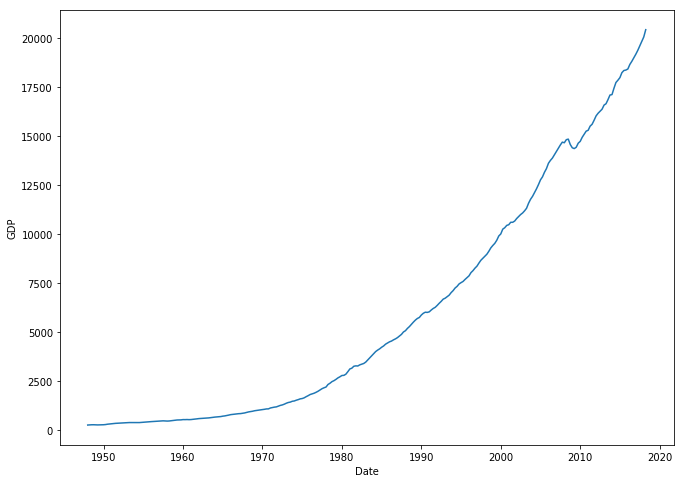

In [4]:
plt.plot(dataset['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP');
plt.gcf().set_size_inches(11,8)

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [5]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

A quick plot...

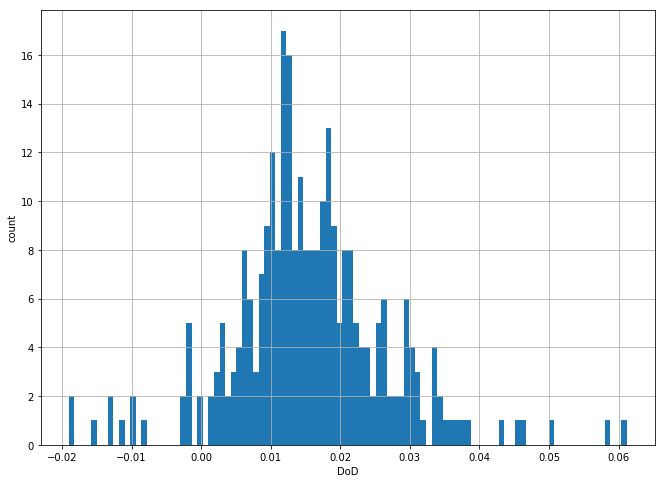

In [6]:
dataset['diff'].hist(bins=100)
plt.xlabel('DoD')
plt.ylabel('count')
plt.gcf().set_size_inches(11, 8)

## Training and Testing datasets 
The y values are just the next x value

In [7]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [8]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 188 training points and 92 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [9]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(188, 1, 1)
(92, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [10]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [11]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
188/188 [==============================] - 0s 1ms/step - loss: 0.1079
Epoch 2/100
188/188 [==============================] - 0s 116us/step - loss: 0.0999
Epoch 3/100
188/188 [==============================] - 0s 97us/step - loss: 0.0931
Epoch 4/100
188/188 [==============================] - 0s 96us/step - loss: 0.0878
Epoch 5/100
188/188 [==============================] - 0s 93us/step - loss: 0.0838
Epoch 6/100
188/188 [==============================] - 0s 90us/step - loss: 0.0807
Epoch 7/100
188/188 [==============================] - 0s 94us/step - loss: 0.0779
Epoch 8/100
188/188 [==============================] - 0s 109us/step - loss: 0.0764
Epoch 9/100
188/188 [==============================] - 0s 108us/step - loss: 0.0750
Epoch 10/100
188/188 [==============================] - 0s 100us/step - loss: 0.0741
Epoch 11/100
188/188 [==============================] - 0s 101us/step - loss: 0.0737
Epoch 12/100
188/188 [===========

188/188 [==============================] - 0s 98us/step - loss: 0.0722
Epoch 96/100
188/188 [==============================] - 0s 91us/step - loss: 0.0722
Epoch 97/100
188/188 [==============================] - 0s 88us/step - loss: 0.0723
Epoch 98/100
188/188 [==============================] - 0s 85us/step - loss: 0.0723
Epoch 99/100
188/188 [==============================] - 0s 90us/step - loss: 0.0724
Epoch 100/100
188/188 [==============================] - 0s 88us/step - loss: 0.0722


## Make predictions

In [12]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

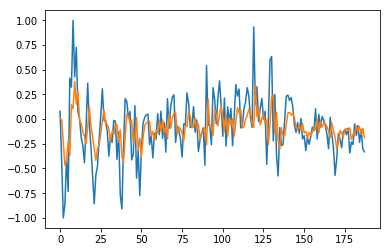

In [13]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [14]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

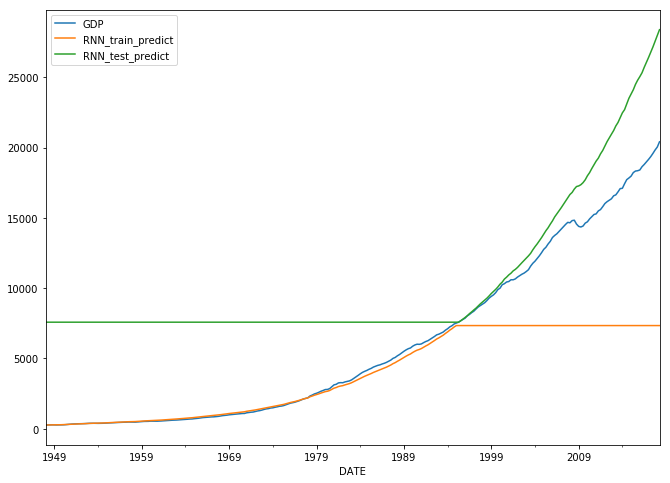

In [15]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# LSTM
Let's now try using a slightly more sophisticated architecture

In [16]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [18]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 0.1022
Epoch 2/500
188/188 [==============================] - 0s 94us/step - loss: 0.1005
Epoch 3/500
188/188 [==============================] - 0s 101us/step - loss: 0.0992
Epoch 4/500
188/188 [==============================] - 0s 99us/step - loss: 0.0977
Epoch 5/500
188/188 [==============================] - 0s 88us/step - loss: 0.0966
Epoch 6/500
188/188 [==============================] - 0s 89us/step - loss: 0.0958
Epoch 7/500
188/188 [==============================] - 0s 91us/step - loss: 0.0948
Epoch 8/500
188/188 [==============================] - 0s 88us/step - loss: 0.0942
Epoch 9/500
188/188 [==============================] - 0s 92us/step - loss: 0.0935
Epoch 10/500
188/188 [==============================] - 0s 89us/step - loss: 0.0930
Epoch 11/500
188/188 [==============================] - 0s 88us/step - loss: 0.0926
Epoch 12/500
188/188 [==============================] - 0s 86us/step - loss: 0.0920
E

188/188 [==============================] - 0s 87us/step - loss: 0.0722
Epoch 99/500
188/188 [==============================] - 0s 88us/step - loss: 0.0722
Epoch 100/500
188/188 [==============================] - 0s 90us/step - loss: 0.0722
Epoch 101/500
188/188 [==============================] - 0s 82us/step - loss: 0.0721
Epoch 102/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 103/500
188/188 [==============================] - 0s 79us/step - loss: 0.0722
Epoch 104/500
188/188 [==============================] - 0s 89us/step - loss: 0.0721
Epoch 105/500
188/188 [==============================] - 0s 86us/step - loss: 0.0721
Epoch 106/500
188/188 [==============================] - 0s 90us/step - loss: 0.0721
Epoch 107/500
188/188 [==============================] - 0s 82us/step - loss: 0.0721
Epoch 108/500
188/188 [==============================] - 0s 85us/step - loss: 0.0721
Epoch 109/500
188/188 [==============================] - 0s 87us/step - loss: 0.

188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 195/500
188/188 [==============================] - 0s 85us/step - loss: 0.0720
Epoch 196/500
188/188 [==============================] - 0s 85us/step - loss: 0.0721
Epoch 197/500
188/188 [==============================] - 0s 87us/step - loss: 0.0720
Epoch 198/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 199/500
188/188 [==============================] - 0s 85us/step - loss: 0.0721
Epoch 200/500
188/188 [==============================] - 0s 82us/step - loss: 0.0720
Epoch 201/500
188/188 [==============================] - 0s 81us/step - loss: 0.0721
Epoch 202/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 203/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 204/500
188/188 [==============================] - 0s 86us/step - loss: 0.0721
Epoch 205/500
188/188 [==============================] - 0s 83us/step - loss: 0

188/188 [==============================] - 0s 90us/step - loss: 0.0720
Epoch 291/500
188/188 [==============================] - 0s 86us/step - loss: 0.0720
Epoch 292/500
188/188 [==============================] - 0s 87us/step - loss: 0.0720
Epoch 293/500
188/188 [==============================] - 0s 92us/step - loss: 0.0720
Epoch 294/500
188/188 [==============================] - 0s 93us/step - loss: 0.0720
Epoch 295/500
188/188 [==============================] - 0s 87us/step - loss: 0.0720
Epoch 296/500
188/188 [==============================] - 0s 92us/step - loss: 0.0720
Epoch 297/500
188/188 [==============================] - 0s 93us/step - loss: 0.0720
Epoch 298/500
188/188 [==============================] - 0s 90us/step - loss: 0.0721
Epoch 299/500
188/188 [==============================] - 0s 89us/step - loss: 0.0721
Epoch 300/500
188/188 [==============================] - 0s 93us/step - loss: 0.0721
Epoch 301/500
188/188 [==============================] - 0s 88us/step - loss: 0

188/188 [==============================] - 0s 85us/step - loss: 0.0720
Epoch 387/500
188/188 [==============================] - 0s 96us/step - loss: 0.0721
Epoch 388/500
188/188 [==============================] - 0s 99us/step - loss: 0.0720
Epoch 389/500
188/188 [==============================] - 0s 85us/step - loss: 0.0720
Epoch 390/500
188/188 [==============================] - 0s 88us/step - loss: 0.0720
Epoch 391/500
188/188 [==============================] - 0s 82us/step - loss: 0.0720
Epoch 392/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 393/500
188/188 [==============================] - 0s 83us/step - loss: 0.0720
Epoch 394/500
188/188 [==============================] - 0s 82us/step - loss: 0.0720
Epoch 395/500
188/188 [==============================] - 0s 88us/step - loss: 0.0720
Epoch 396/500
188/188 [==============================] - 0s 86us/step - loss: 0.0720
Epoch 397/500
188/188 [==============================] - 0s 83us/step - loss: 0

188/188 [==============================] - 0s 80us/step - loss: 0.0721
Epoch 483/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 484/500
188/188 [==============================] - 0s 85us/step - loss: 0.0721
Epoch 485/500
188/188 [==============================] - 0s 80us/step - loss: 0.0720
Epoch 486/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 487/500
188/188 [==============================] - 0s 81us/step - loss: 0.0720
Epoch 488/500
188/188 [==============================] - 0s 80us/step - loss: 0.0720
Epoch 489/500
188/188 [==============================] - 0s 77us/step - loss: 0.0720
Epoch 490/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 491/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 492/500
188/188 [==============================] - 0s 75us/step - loss: 0.0720
Epoch 493/500
188/188 [==============================] - 0s 82us/step - loss: 0

Calculate the predicted values

In [19]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

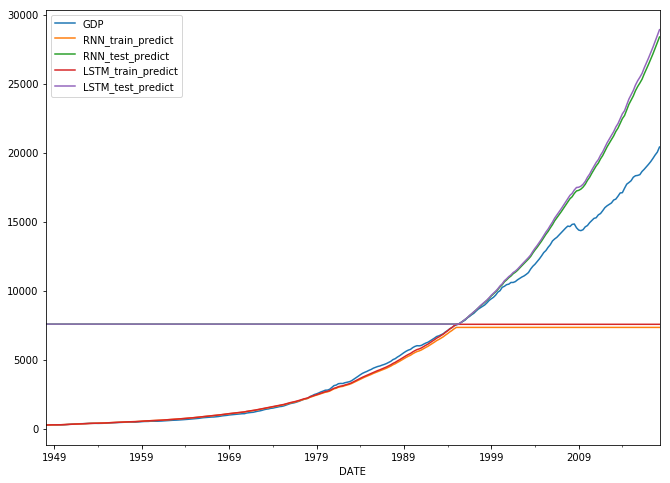

In [20]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 'LSTM_train_predict', 'LSTM_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [21]:
X2 = np.concatenate([X[0:-4], X[1:-3], X[2:-2], X[3:-1]], axis=1)
y2 = X[4:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 188 training points and 88 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [22]:
tf.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(188, 4, 1)
(88, 4, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [23]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [24]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, batch_size=12)

Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0933
Epoch 2/500
188/188 [==============================] - 0s 491us/step - loss: 0.0876
Epoch 3/500
188/188 [==============================] - 0s 485us/step - loss: 0.0845
Epoch 4/500
188/188 [==============================] - 0s 449us/step - loss: 0.0829
Epoch 5/500
188/188 [==============================] - 0s 450us/step - loss: 0.0814
Epoch 6/500
188/188 [==============================] - 0s 448us/step - loss: 0.0803
Epoch 7/500
188/188 [==============================] - 0s 440us/step - loss: 0.0794
Epoch 8/500
188/188 [==============================] - 0s 423us/step - loss: 0.0787
Epoch 9/500
188/188 [==============================] - 0s 432us/step - loss: 0.0778
Epoch 10/500
188/188 [==============================] - 0s 445us/step - loss: 0.0771
Epoch 11/500
188/188 [==============================] - 0s 477us/step - loss: 0.0766
Epoch 12/500
188/188 [==============================] - 0s 453us/step - loss

188/188 [==============================] - 0s 356us/step - loss: 0.0641
Epoch 98/500
188/188 [==============================] - 0s 366us/step - loss: 0.0641
Epoch 99/500
188/188 [==============================] - 0s 413us/step - loss: 0.0643
Epoch 100/500
188/188 [==============================] - 0s 427us/step - loss: 0.0642
Epoch 101/500
188/188 [==============================] - 0s 445us/step - loss: 0.0640
Epoch 102/500
188/188 [==============================] - 0s 449us/step - loss: 0.0641
Epoch 103/500
188/188 [==============================] - 0s 444us/step - loss: 0.0642
Epoch 104/500
188/188 [==============================] - 0s 441us/step - loss: 0.0642
Epoch 105/500
188/188 [==============================] - 0s 446us/step - loss: 0.0640
Epoch 106/500
188/188 [==============================] - 0s 458us/step - loss: 0.0641
Epoch 107/500
188/188 [==============================] - 0s 490us/step - loss: 0.0641
Epoch 108/500
188/188 [==============================] - 0s 474us/step

188/188 [==============================] - 0s 445us/step - loss: 0.0637
Epoch 193/500
188/188 [==============================] - 0s 409us/step - loss: 0.0638
Epoch 194/500
188/188 [==============================] - 0s 364us/step - loss: 0.0640
Epoch 195/500
188/188 [==============================] - 0s 388us/step - loss: 0.0638
Epoch 196/500
188/188 [==============================] - 0s 386us/step - loss: 0.0638
Epoch 197/500
188/188 [==============================] - 0s 416us/step - loss: 0.0637
Epoch 198/500
188/188 [==============================] - 0s 481us/step - loss: 0.0637
Epoch 199/500
188/188 [==============================] - 0s 496us/step - loss: 0.0637
Epoch 200/500
188/188 [==============================] - 0s 463us/step - loss: 0.0638
Epoch 201/500
188/188 [==============================] - 0s 451us/step - loss: 0.0636
Epoch 202/500
188/188 [==============================] - 0s 448us/step - loss: 0.0637
Epoch 203/500
188/188 [==============================] - 0s 459us/st

188/188 [==============================] - 0s 449us/step - loss: 0.0635
Epoch 288/500
188/188 [==============================] - 0s 438us/step - loss: 0.0636
Epoch 289/500
188/188 [==============================] - 0s 460us/step - loss: 0.0635
Epoch 290/500
188/188 [==============================] - 0s 465us/step - loss: 0.0635
Epoch 291/500
188/188 [==============================] - 0s 439us/step - loss: 0.0636
Epoch 292/500
188/188 [==============================] - 0s 446us/step - loss: 0.0634
Epoch 293/500
188/188 [==============================] - 0s 457us/step - loss: 0.0637
Epoch 294/500
188/188 [==============================] - 0s 451us/step - loss: 0.0634
Epoch 295/500
188/188 [==============================] - 0s 457us/step - loss: 0.0637
Epoch 296/500
188/188 [==============================] - 0s 448us/step - loss: 0.0637
Epoch 297/500
188/188 [==============================] - 0s 441us/step - loss: 0.0636
Epoch 298/500
188/188 [==============================] - 0s 472us/st

188/188 [==============================] - 0s 437us/step - loss: 0.0633
Epoch 383/500
188/188 [==============================] - 0s 446us/step - loss: 0.0634
Epoch 384/500
188/188 [==============================] - 0s 485us/step - loss: 0.0632
Epoch 385/500
188/188 [==============================] - 0s 471us/step - loss: 0.0637
Epoch 386/500
188/188 [==============================] - 0s 440us/step - loss: 0.0636
Epoch 387/500
188/188 [==============================] - 0s 439us/step - loss: 0.0632
Epoch 388/500
188/188 [==============================] - 0s 417us/step - loss: 0.0632
Epoch 389/500
188/188 [==============================] - 0s 433us/step - loss: 0.0633
Epoch 390/500
188/188 [==============================] - 0s 437us/step - loss: 0.0636
Epoch 391/500
188/188 [==============================] - 0s 459us/step - loss: 0.0633
Epoch 392/500
188/188 [==============================] - 0s 470us/step - loss: 0.0640
Epoch 393/500
188/188 [==============================] - 0s 511us/st

188/188 [==============================] - 0s 445us/step - loss: 0.0629
Epoch 478/500
188/188 [==============================] - 0s 426us/step - loss: 0.0629
Epoch 479/500
188/188 [==============================] - 0s 429us/step - loss: 0.0628
Epoch 480/500
188/188 [==============================] - 0s 442us/step - loss: 0.0631
Epoch 481/500
188/188 [==============================] - 0s 501us/step - loss: 0.0627
Epoch 482/500
188/188 [==============================] - 0s 536us/step - loss: 0.0628
Epoch 483/500
188/188 [==============================] - 0s 478us/step - loss: 0.0627
Epoch 484/500
188/188 [==============================] - 0s 439us/step - loss: 0.0628
Epoch 485/500
188/188 [==============================] - 0s 461us/step - loss: 0.0628
Epoch 486/500
188/188 [==============================] - 0s 460us/step - loss: 0.0628
Epoch 487/500
188/188 [==============================] - 0s 547us/step - loss: 0.0628
Epoch 488/500
188/188 [==============================] - 0s 475us/st

In [25]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 1
dataset['LSTM3_test_predict'] = 1
dataset.loc[4:train_points+4, 'LSTM3_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+6:, 'LSTM3_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM3_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM3_train_predict'].cumprod()
dataset['LSTM3_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM3_test_predict'].cumprod()

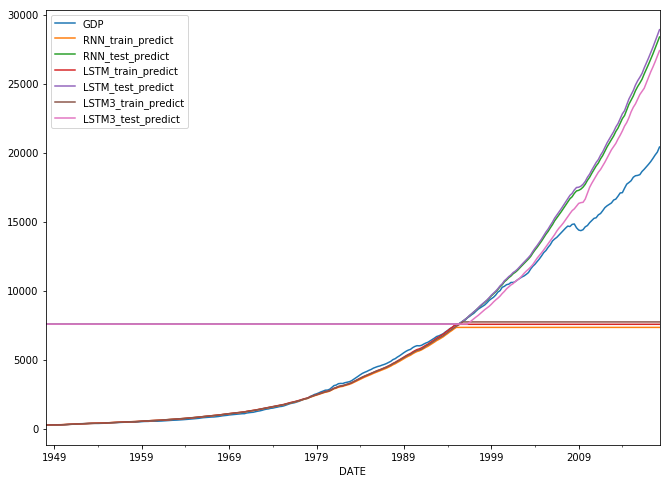

In [26]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 
                'LSTM_train_predict', 'LSTM_test_predict', 
                'LSTM3_train_predict', 'LSTM3_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# GRU

In [27]:
model = Sequential()
model.add(GRU(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [29]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
188/188 [==============================] - 1s 3ms/step - loss: 0.0857
Epoch 2/500
188/188 [==============================] - 0s 88us/step - loss: 0.0844
Epoch 3/500
188/188 [==============================] - 0s 84us/step - loss: 0.0833
Epoch 4/500
188/188 [==============================] - 0s 88us/step - loss: 0.0821
Epoch 5/500
188/188 [==============================] - 0s 89us/step - loss: 0.0812
Epoch 6/500
188/188 [==============================] - 0s 89us/step - loss: 0.0806
Epoch 7/500
188/188 [==============================] - 0s 84us/step - loss: 0.0799
Epoch 8/500
188/188 [==============================] - 0s 88us/step - loss: 0.0793
Epoch 9/500
188/188 [==============================] - 0s 84us/step - loss: 0.0789
Epoch 10/500
188/188 [==============================] - 0s 81us/step - loss: 0.0785
Epoch 11/500
188/188 [==============================] - 0s 82us/step - loss: 0.0781
Epoch 12/500
188/188 [==============================] - 0s 79us/step - loss: 0.0778
Ep

188/188 [==============================] - 0s 75us/step - loss: 0.0723
Epoch 99/500
188/188 [==============================] - 0s 73us/step - loss: 0.0722
Epoch 100/500
188/188 [==============================] - 0s 73us/step - loss: 0.0723
Epoch 101/500
188/188 [==============================] - 0s 77us/step - loss: 0.0722
Epoch 102/500
188/188 [==============================] - 0s 75us/step - loss: 0.0722
Epoch 103/500
188/188 [==============================] - 0s 76us/step - loss: 0.0722
Epoch 104/500
188/188 [==============================] - 0s 78us/step - loss: 0.0722
Epoch 105/500
188/188 [==============================] - 0s 65us/step - loss: 0.0722
Epoch 106/500
188/188 [==============================] - 0s 74us/step - loss: 0.0722
Epoch 107/500
188/188 [==============================] - 0s 74us/step - loss: 0.0722
Epoch 108/500
188/188 [==============================] - 0s 74us/step - loss: 0.0722
Epoch 109/500
188/188 [==============================] - 0s 76us/step - loss: 0.

188/188 [==============================] - 0s 75us/step - loss: 0.0721
Epoch 195/500
188/188 [==============================] - 0s 83us/step - loss: 0.0721
Epoch 196/500
188/188 [==============================] - 0s 74us/step - loss: 0.0722
Epoch 197/500
188/188 [==============================] - 0s 82us/step - loss: 0.0721
Epoch 198/500
188/188 [==============================] - 0s 81us/step - loss: 0.0721
Epoch 199/500
188/188 [==============================] - 0s 78us/step - loss: 0.0721
Epoch 200/500
188/188 [==============================] - 0s 81us/step - loss: 0.0722
Epoch 201/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 202/500
188/188 [==============================] - 0s 77us/step - loss: 0.0722
Epoch 203/500
188/188 [==============================] - 0s 81us/step - loss: 0.0721
Epoch 204/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 205/500
188/188 [==============================] - 0s 73us/step - loss: 0

188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 291/500
188/188 [==============================] - 0s 78us/step - loss: 0.0721
Epoch 292/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 293/500
188/188 [==============================] - 0s 80us/step - loss: 0.0721
Epoch 294/500
188/188 [==============================] - 0s 80us/step - loss: 0.0721
Epoch 295/500
188/188 [==============================] - 0s 77us/step - loss: 0.0721
Epoch 296/500
188/188 [==============================] - 0s 76us/step - loss: 0.0721
Epoch 297/500
188/188 [==============================] - 0s 80us/step - loss: 0.0721
Epoch 298/500
188/188 [==============================] - 0s 74us/step - loss: 0.0721
Epoch 299/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 300/500
188/188 [==============================] - 0s 84us/step - loss: 0.0721
Epoch 301/500
188/188 [==============================] - 0s 78us/step - loss: 0

188/188 [==============================] - 0s 77us/step - loss: 0.0722
Epoch 387/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 388/500
188/188 [==============================] - 0s 79us/step - loss: 0.0720
Epoch 389/500
188/188 [==============================] - 0s 78us/step - loss: 0.0721
Epoch 390/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 391/500
188/188 [==============================] - 0s 80us/step - loss: 0.0721
Epoch 392/500
188/188 [==============================] - 0s 80us/step - loss: 0.0720
Epoch 393/500
188/188 [==============================] - 0s 81us/step - loss: 0.0721
Epoch 394/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 395/500
188/188 [==============================] - 0s 76us/step - loss: 0.0720
Epoch 396/500
188/188 [==============================] - 0s 79us/step - loss: 0.0721
Epoch 397/500
188/188 [==============================] - 0s 79us/step - loss: 0

188/188 [==============================] - 0s 83us/step - loss: 0.0720
Epoch 483/500
188/188 [==============================] - 0s 77us/step - loss: 0.0720
Epoch 484/500
188/188 [==============================] - 0s 77us/step - loss: 0.0720
Epoch 485/500
188/188 [==============================] - 0s 78us/step - loss: 0.0720
Epoch 486/500
188/188 [==============================] - 0s 77us/step - loss: 0.0720
Epoch 487/500
188/188 [==============================] - 0s 78us/step - loss: 0.0721
Epoch 488/500
188/188 [==============================] - 0s 77us/step - loss: 0.0720
Epoch 489/500
188/188 [==============================] - 0s 76us/step - loss: 0.0720
Epoch 490/500
188/188 [==============================] - 0s 71us/step - loss: 0.0720
Epoch 491/500
188/188 [==============================] - 0s 76us/step - loss: 0.0720
Epoch 492/500
188/188 [==============================] - 0s 80us/step - loss: 0.0720
Epoch 493/500
188/188 [==============================] - 0s 75us/step - loss: 0

In [30]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['GRU_train_predict'] = 1
dataset['GRU_test_predict'] = 1
dataset.loc[1:train_points+1, 'GRU_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'GRU_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['GRU_train_predict'] = dataset.iloc[0]['GDP']*dataset['GRU_train_predict'].cumprod()
dataset['GRU_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['GRU_test_predict'].cumprod()

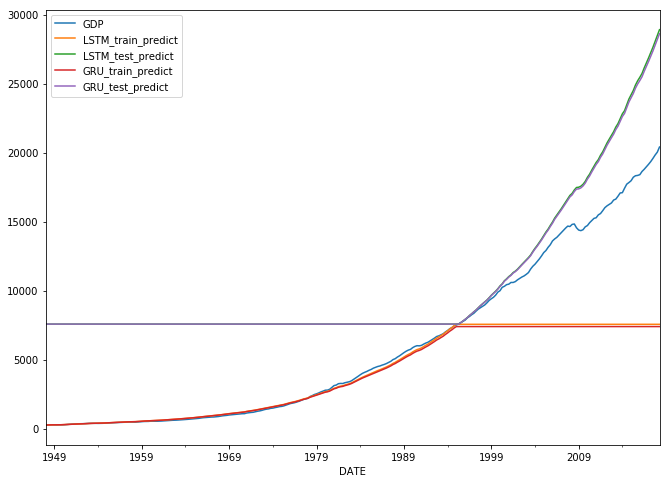

In [31]:
dataset[['GDP', #'RNN_train_predict', 'RNN_test_predict', 
                'LSTM_train_predict', 'LSTM_test_predict', 
                #'LSTM3_train_predict', 'LSTM3_test_predict',
                'GRU_train_predict', 'GRU_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)